In [115]:
import torchvision.models as models
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
import torch 
import PIL
from PIL import Image 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import sys
import argparse

In [116]:
# parser = argparse.ArgumentParser()
# parser.add_argument('-c','--content',default="lion.jpeg") 
# parser.add_argument('-s','--style',default='candy.jpeg') 
# args = parser.parse_args()


In [117]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1)

    def forward(self, img):
        return (img - self.mean) / self.std



In [118]:
class mod_vgg(nn.Module):
    def __init__(self,model,index):
        super().__init__()
        l=[]
        for i,r in enumerate(model.children()):
            if i==index:
                l.append(nn.Flatten(start_dim=0, end_dim=-1))
            l.append(r)
        self.layers = nn.ModuleList(l)
        

    def forward(self, x):
        for r  in self.layers:
            x=r(x)
        return x




In [119]:
content_directory='content'
style_directory='style'

# content_image = Image.open(f'{content_directory}/{args.content}') 
# style_image=Image.open(f'{style_directory}/{args.style}')
content_image = Image.open(f'{content_directory}/booth.jpeg') 
style_image=Image.open(f'{style_directory}/starry.jpeg')

square_size=512

transform = transforms.Compose([
    transforms.Resize((square_size, square_size)),
    transforms.ToTensor(),
    
]) 
  
content_tensor = transform(content_image)
style_tensor=transform(style_image)

mod_model=mod_vgg(model,2)


feature_indices=[3,8,17,26]
feature_indices=[1,3,6,8,11,13,15,17,20,22,24,26]


temp_layers=list(list(list(mod_model.children())[0].children())[0])
temp_layers.insert(0,Normalization())



In [120]:
def get_activations(image,style=False):
    activations=[]
    for r in range(len(temp_layers)):
        #print(r,temp_layers[r])
        image=temp_layers[r](image)

        if r in feature_indices:
            activations.append(image.clone())
    return activations

def rotate(image):
    all_activations=[]
    for angle in [0,90,180,270]:
        temp_image=image.clone()
        for _ in range(int(angle/90)):
            temp_image=torch.rot90(temp_image,k=1,dims=(1,2))
        all_activations.append(get_activations(temp_image))
    return all_activations
    

model.requires_grad_(False)
for r in temp_layers:
    r.requires_grad_(False)

content_activations=get_activations(content_tensor)
style_activations=rotate(style_tensor)

def interp_concat(activation_list):
    activation_list=[F.interpolate(x.unsqueeze(0),(int(square_size/4),int(square_size/4)),mode='bilinear') for x in activation_list]
    activation_list=torch.cat(activation_list, dim=1).squeeze(0)
    return activation_list


def post_process(activation_list):
    activation_list=interp_concat(activation_list)
    activation_list=activation_list.view(activation_list.shape[0],-1)
    activation_list=torch.transpose(activation_list, 0, 1)
    return activation_list

content_hyperstack=post_process(content_activations)
print(content_hyperstack.shape)


temp_style=[post_process(r) for r in style_activations]
style_hyperstack=torch.cat(temp_style, dim=0)
print(style_hyperstack.shape)

#Zeroing out the vectors
mean_content_tensor = content_hyperstack.mean(dim=(0))
content_hyperstack-= mean_content_tensor

mean_style_tensor=style_hyperstack.mean(dim=(0))
style_hyperstack-= mean_style_tensor

d=style_hyperstack.shape[1]
#0th index layers starts with normalization, 1st index layers is conv2d

torch.Size([16384, 3456])
torch.Size([65536, 3456])


In [121]:
dot_product_matrix = torch.mm(content_hyperstack, style_hyperstack.t())  # Shape (16384, 65536)

# Compute norms (magnitudes) of the tensors
tensor1_norms = torch.norm(content_hyperstack, dim=1, keepdim=True)  # Shape (16384, 1)
tensor2_norms = torch.norm(style_hyperstack, dim=1)  # Shape (65536,)

# Compute cosine similarity matrix
cosine_similarity_matrix = dot_product_matrix / (tensor1_norms * tensor2_norms)  # Shape (16384, 65536)

del(tensor1_norms)
del(tensor2_norms)
del(dot_product_matrix)

# Find the index of the closest tensor in tensor2 for each tensor in tensor1
_, closest_indices = torch.max(cosine_similarity_matrix, dim=1)

# Gather the closest tensors from tensor2
closest_tensors = style_hyperstack[closest_indices]
closest_tensors+=mean_style_tensor

In [122]:
closest_tensors=closest_tensors.t()
closest_tensors=closest_tensors.view(d,int(square_size/4),int(square_size/4))
closest_tensors.requires_grad=False


closest_tensors.shape

torch.Size([3456, 128, 128])

In [123]:
def overall_loss(img,output,target,variation=False):
#     loss=nn.MSELoss()
#     return loss(output,target)

    target_reshaped = target.view(d, -1).transpose(0, 1)
    output_reshaped = output.view(d, -1).transpose(0, 1)

    # Compute cosine similarity for each corresponding 960-dimensional tensor
    cos_sim = F.cosine_similarity(target_reshaped, output_reshaped, dim=1)

    # Compute the mean cosine similarity across all spatial locations
    mean_cos_sim = cos_sim.mean()

    # Multiply by -1 to get the final loss value
    loss = -mean_cos_sim
    
    weight=1
    
    if variation:
        c_img, h_img, w_img = img.size()
        tv_h = torch.pow(img[:,1:,:]-img[:,:-1,:], 2).sum()
        tv_w = torch.pow(img[:,:,1:]-img[:,:,:-1], 2).sum()
        loss+=weight*(tv_h+tv_w)/(c_img*h_img*w_img)
        
    return loss

In [124]:
generated_image=content_tensor.clone()
generated_image.requires_grad=True
activations=interp_concat(get_activations(generated_image))
activations.shape

torch.Size([3456, 128, 128])

iteration:  0


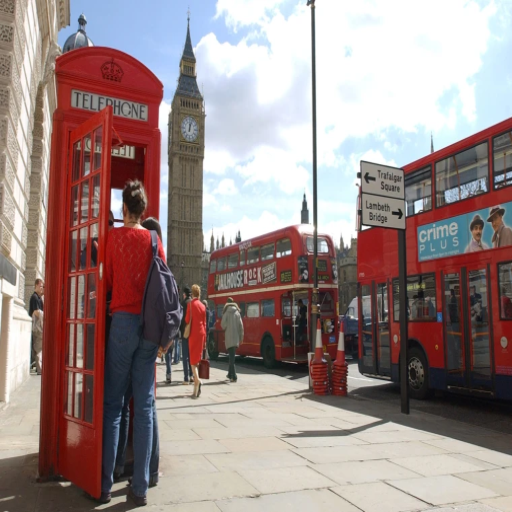

In [ ]:
iterations=600

import torch.optim as optim

generated_image=content_tensor.clone()
generated_image.requires_grad=True

LBFGS_optimizer=optim.LBFGS([generated_image])
optimizer=optim.SGD([generated_image],lr=.2)
ADAM_optimizer=optim.Adam([generated_image], lr=.02, betas=(.9, .999))

invTrans2 = transforms.Compose([transforms.ToPILImage()])

i=[0]
while i[0]<iterations:
    # making predictions with forward pass
    if i[0]%100==0:
        print('iteration: ',i[0])
        inversed_image=invTrans2(generated_image.clone())
        display(inversed_image)
    def closure():
        with torch.no_grad():
            generated_image.clamp_(0, 1)
        i[0]+=1
        activations=interp_concat(get_activations(generated_image))
        # calculating the loss between original and predicted data points
        computed_loss=overall_loss(generated_image,activations,closest_tensors,variation=True)
        ADAM_optimizer.zero_grad()
        computed_loss.backward()
        return computed_loss
    # updateing the parameters after each iteration
    ADAM_optimizer.step(closure)
    

How to improve: Switch to Adam(use authors hyperparams),increase lr, and start using cosine loss function since that is what was used to pick style tensors.

In [ ]:
with torch.no_grad():
    generated_image.clamp_(0, 1)

inversed_image=invTrans2(generated_image.clone())
display(inversed_image)

You now need to implement Feature Splitting and Recomputing the Target Hypercolumns after every iteration